# ConvNeXtTiny for Glaucoma Binary Classification
* Model: ConvNeXtTiny with GlobalMaxPool2D and a Regularized Dense Layer
* Preprocessing: Noise, Flipping, Rotation, Shearing, Brightness, Shifting, Zooming
* Dataset: Training set doubled with 2 uniquely seeded generators combined; batch size 8; image size 256x256
* Meta-Learning: ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=1, min_lr=1e-5); Model checkpoints on best validation loss

## Libraries

In [ ]:
import pandas as pd
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from tensorflow.keras import regularizers, Model
from keras.layers import Dense, GlobalMaxPool2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from keras.models import Model
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import keras
import numpy as np
import random
import shutil

#from tensorflow.keras.applications.xception import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setup data splits in generators

In [ ]:
target = 256 # number of pixels. change this to 512 if you want to use the full image size. note: will slow computations

dataPath = '/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512/'

# inject noise but keep dark parts black
def addNoise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    ret, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

    randStd = random.uniform(0, 10.0)
    gaussian = np.random.normal(randStd*-1, randStd, (target, target,3))
    noisy_image = image + gaussian
    image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    image[mask == 0] = [0,0,0]
    #image = preprocess_input(image)
    return image

# combine two unique generators using noise injection and moderate preprocessing
batchSize = 8
trainDataGen = ImageDataGenerator(preprocessing_function=addNoise, horizontal_flip=True,vertical_flip=True, channel_shift_range=10, width_shift_range=0.05, height_shift_range=0.05,rotation_range=360,shear_range=30, brightness_range=(0.95, 1.05),  fill_mode = 'constant', cval=0, zoom_range=0.05)
trainGen1 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=0)
trainGen2 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=1)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=None)
valGen = valDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=None)
testGen = testDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'test', color_mode='rgb')

Found 8000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


## Create a ConvNeXtTiny instance

In [ ]:
# simple model that uses ConvNeXtTiny backbone; accomodate for overfitting with a regularized dense layer after backbone
def getModel(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))

    transfer = keras.applications.ConvNeXtTiny(
        weights='imagenet', include_preprocessing=True, include_top=False, input_tensor=model_input
    )
    x = transfer.output
    x = GlobalMaxPool2D()(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
    model_output = Dense(1, activation='sigmoid') (x)

    return keras.Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)

## Model Meta-Learning Configurations

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=1, min_lr=1e-5)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='val-best.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## Model Training
Note: No training on the doubled dataset yet for quicker convergence

In [ ]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(trainGen1, steps_per_epoch = len(trainGen1),validation_data=valGen, validation_steps=len(valGen), epochs=20, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/20
1000/1000 [==============================] - 307s 269ms/step - loss: 62.3853 - binary_accuracy: 0.8026 - auc_3: 0.8875 - precision_3: 0.8065 - recall_3: 0.7962 - val_loss: 1.0240 - val_binary_accuracy: 0.9026 - val_auc_3: 0.9621 - val_precision_3: 0.8914 - val_recall_3: 0.9169 - lr: 1.0000e-04
Epoch 2/20
1000/1000 [==============================] - 267s 267ms/step - loss: 0.6353 - binary_accuracy: 0.8737 - auc_3: 0.9399 - precision_3: 0.8664 - recall_3: 0.8838 - val_loss: 0.4226 - val_binary_accuracy: 0.9104 - val_auc_3: 0.9665 - val_precision_3: 0.9093 - val_recall_3: 0.9117 - lr: 1.0000e-04
Epoch 3/20
1000/1000 [==============================] - 267s 267ms/step - loss: 0.4403 - binary_accuracy: 0.8930 - auc_3: 0.9536 - precision_3: 0.8857 - recall_3: 0.9025 - val_loss: 0.4062 - val_binary_accuracy: 0.8974 - val_auc_3: 0.9624 - val_precision_3: 0.9347 - val_recall_3: 0.8545 - lr: 1.0000e-04
Epoch 4/20
1000/1000 [==============================] - 266s 266ms/step - loss: 0.40

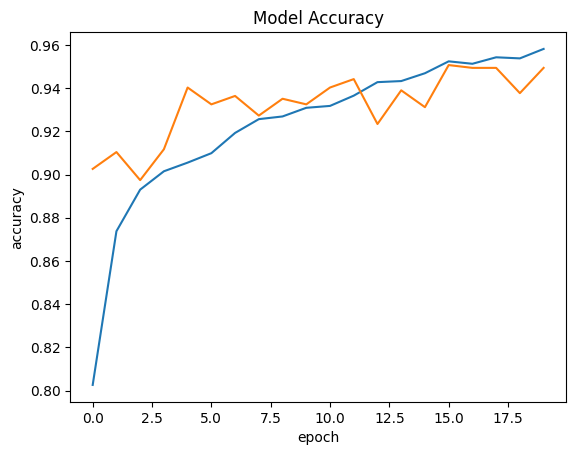

In [ ]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
# evaluate using best epoch model according to validation loss
model.save('pretrained.h5')
model.load_weights('/kaggle/working/val-best.h5')
model.evaluate(testGen)

770/770 [==============================] - 19s 24ms/step - loss: 0.2630 - binary_accuracy: 0.9377 - auc_3: 0.9825 - precision_3: 0.9080 - recall_3: 0.9740


[0.26296645402908325,
 0.9376623630523682,
 0.9825130701065063,
 0.9079903364181519,
 0.9740259647369385]

# Double training data with the other uniqely seeded training generator to prevent overfitting and continue training

In [ ]:
model.load_weights('pretrained.h5')
history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=5, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/5
2000/2000 [==============================] - 504s 252ms/step - loss: 0.2012 - binary_accuracy: 0.9582 - auc_3: 0.9905 - precision_3: 0.9533 - recall_3: 0.9638 - val_loss: 0.2226 - val_binary_accuracy: 0.9571 - val_auc_3: 0.9844 - val_precision_3: 0.9513 - val_recall_3: 0.9636 - lr: 6.6342e-05
Epoch 2/5
2000/2000 [==============================] - 502s 251ms/step - loss: 0.1880 - binary_accuracy: 0.9645 - auc_3: 0.9921 - precision_3: 0.9596 - recall_3: 0.9699 - val_loss: 0.2511 - val_binary_accuracy: 0.9455 - val_auc_3: 0.9781 - val_precision_3: 0.9501 - val_recall_3: 0.9403 - lr: 6.6342e-05
Epoch 3/5
2000/2000 [==============================] - 501s 250ms/step - loss: 0.1775 - binary_accuracy: 0.9668 - auc_3: 0.9929 - precision_3: 0.9611 - recall_3: 0.9729 - val_loss: 0.2357 - val_binary_accuracy: 0.9519 - val_auc_3: 0.9835 - val_precision_3: 0.9328 - val_recall_3: 0.9740 - lr: 6.3025e-05
Epoch 4/5
2000/2000 [==============================] - 501s 250ms/step - loss: 0.1637 - 

In [ ]:
model.save('pretrained2.h5')
model.load_weights('/kaggle/working/val-best.h5')
model.evaluate(testGen)

770/770 [==============================] - 19s 24ms/step - loss: 0.2459 - binary_accuracy: 0.9494 - auc_3: 0.9796 - precision_3: 0.9459 - recall_3: 0.9532


[0.24587659537792206,
 0.9493506550788879,
 0.9795884490013123,
 0.9458763003349304,
 0.9532467722892761]